# Index

### 1. Dealing with categorical features
    1.1. Bucketing bins
    1.2. and One-Hot encoding
    1.3 string integet -> identity, vocabulary_file if don't know go with hash bucket
    
### 2. Feature transformation
    2.1 log
   
    2.2 feature expentions, PolynomialFeatures, extraction
    
    2.3 Scaling or normalizing features within a range 
    
### 3. Feature crossing - (long, lat)

### 4. Row aggregation, group by

    4.1 Moving averages with panda df

### 5. Embedding works with everything space reduction

### 6. Simple model improved after feature engineering.


In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Project constants
LEARN_SIZE = 50
POLY_DEGREE = 2
LEARNING_RATE = 0.001
DISPLAY_STEP = 200
NUM_STEPS = 3000
PRINT_LIMIT = 5

In [3]:
# Immediate execution
tf.enable_eager_execution()
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Load dataset

From Google Machine Learning crash course

In [8]:
housing_df = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

Let's look over the dataset

In [5]:
housing_df.head(PRINT_LIMIT)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


It seems reasonable to evaluate also the dataset features. The dataset is very abundant, so we may limit the data only for the evaluation purposes.

In [7]:
housing_df = housing_df[:LEARN_SIZE]

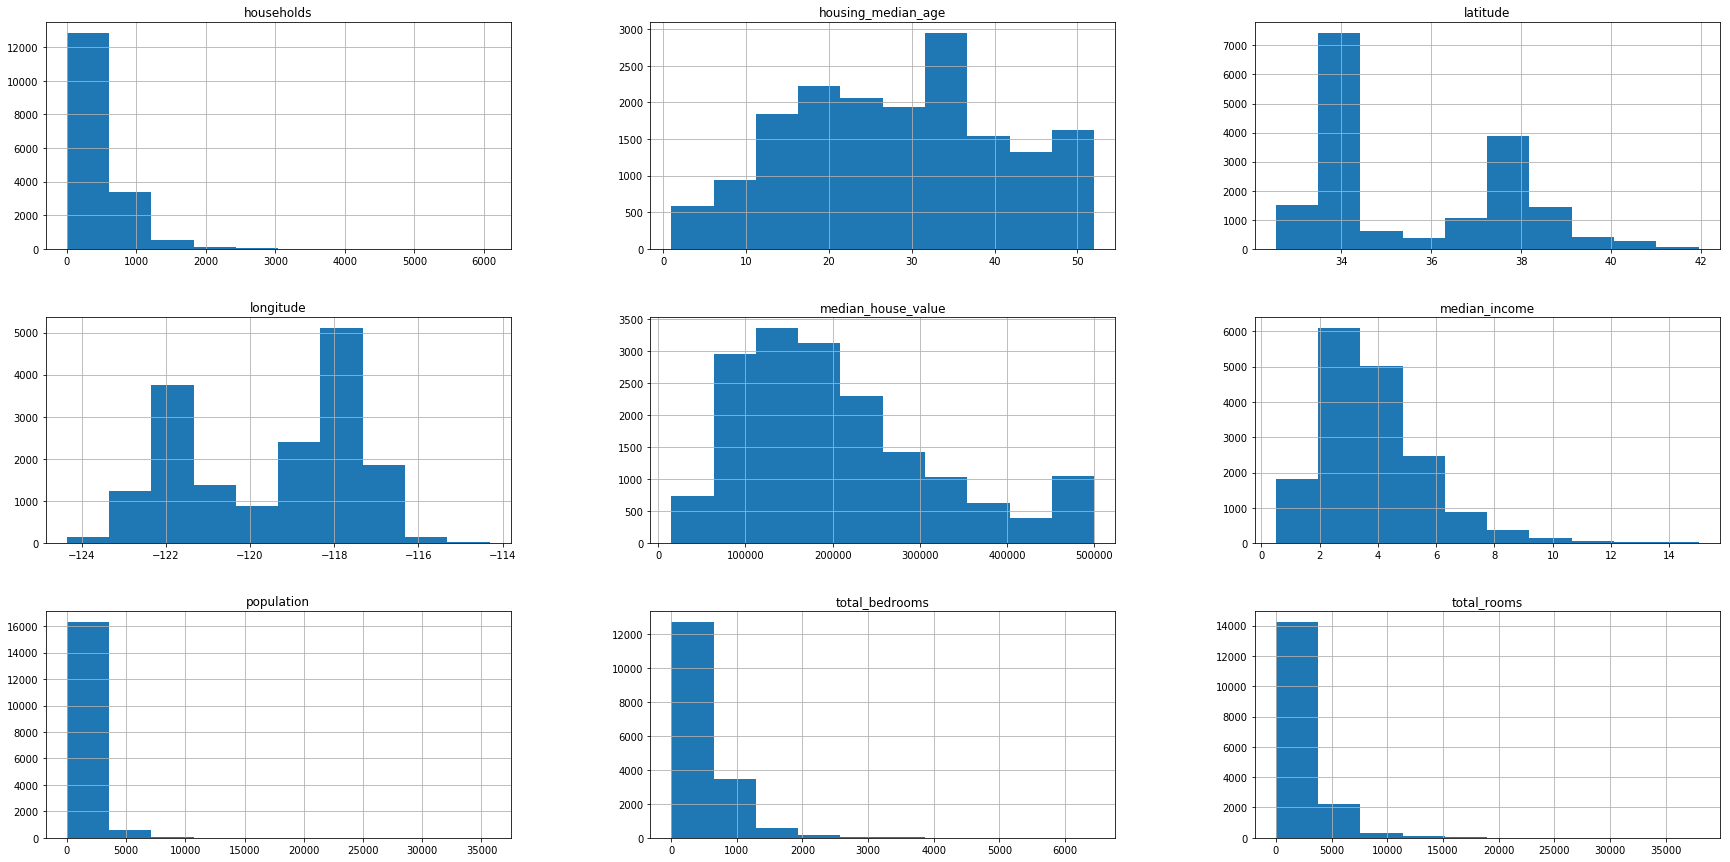

In [9]:
# Initial charts
housing_df.hist(figsize=(30, 15))
plt.show()

We can continue with the Tensorflow data processing now. We may prepare the uniform routine to convert any numeric feature to the Feature Column. This routine also can use predefined transformation function.

In [ ]:
# TODO Delete!!!
def prepare_feature_numeric_column(feature, transformer=None):
    if transformer:
        feature_column = tf.feature_column.numeric_column(feature, normalizer_fn=transformer)
    else:
        feature_column = tf.feature_column.numeric_column(feature)
    feature_tensor = {feature: tf.convert_to_tensor(housing_df[feature])}
    return tf.feature_column.input_layer(feature_tensor, feature_column)

# 1. Dealing with categorical features
1.1. Bucketing bins and One-Hot encoding
1.2

Some numeric values perform better in the categorized form. For example, we can convert 'Housing median age' field into bucketing form. Such operation results in the one-hot-encoded matrix with the parameters separated into predefined bins.

In [ ]:
feature_column = tf.feature_column.numeric_column('housing_median_age')
feature = {'housing_median_age': tf.convert_to_tensor(housing_df['housing_median_age'])}

bucketized_column = tf.feature_column.bucketized_column(
    source_column = feature_column,
    boundaries = [10, 20, 30, 40])

net_age_bucket = tf.feature_column.input_layer(feature, bucketized_column)
print(net_age_bucket.numpy()[:PRINT_LIMIT])

In [ ]:
# one hot encoding no bins

Also a more condensed representation would help in our further calculations. This one-hot-decoding gives us a flat category (rank of current bin).

In [ ]:
bucket_index = tf.reshape(tf.cast(tf.argmax(net_age_bucket, axis=1), tf.float32), [-1, 1])
print(bucket_index.numpy()[:PRINT_LIMIT])

# 2. Feature transformation
## 2.1 log
Tensorflow helps us to make a direct conversion of feature data during the import. For example, we obtain a log transformed data directly.

In [ ]:
#todo do not use function
def log_transformer(x):
    return tf.cast(tf.log(x), dtype=tf.float32)

net_age_log = prepare_feature_numeric_column('housing_median_age', log_transformer)
print(net_age_log.numpy()[:PRINT_LIMIT])

## 2.2 feature 
Data conversion may include a popular polynomial conversion. We will get the polynomially transformed (squared) data in the next cell.

In [ ]:
#todo put multiple polinomials, show the input and output together,plot it
def poly_transformer(x):
    return tf.cast(tf.pow(x, POLY_DEGREE), dtype=tf.float32)

net_age_poly = prepare_feature_numeric_column('housing_median_age', poly_transformer)
print(net_age_poly.numpy()[:PRINT_LIMIT])

## 2.3 Scaling or normalizing features within a range 
Normalization is one of the most popular data transformation methods. Tensorflow helps us to prepare a feature column with zero mean and uniform standard deviation easily.

In [ ]:
# use tf scaling function
val_mean = housing_df['housing_median_age'].mean()
val_std = housing_df['housing_median_age'].std()

def scaler(x):
    return (tf.cast(x, dtype=tf.float32) - val_mean) / val_std

net_age_scale = prepare_feature_numeric_column('housing_median_age', scaler)
print(net_age_scale.numpy()[:PRINT_LIMIT])

# 3. Feature crossing 
Need to mention also more complex data processing methods like feature crossing. They could help us to combine similar variables  for a further simultaneous processing.

In [ ]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [ ]:
# X*Y^-1

In [ ]:
housing_df['rooms_per_person'] = housing_df['total_rooms'] / housing_df['population']
housing_df['rooms_per_person'].head(PRINT_LIMIT)

# 4. Row aggregation, group by,
A detailed dataset evaluation may include grouping of some features. What if we want to estimate average dataset values related to the same housing mean age?

In [ ]:
# mean on axis 1
# use case or remove

In [ ]:
housing_df.groupby(['housing_median_age']).mean().head(PRINT_LIMIT)

## 4.1 Moving averages with panda df
Otherwise we may change the dataset representation by preparing the moving average to smooth possible divagations of variable variability.

In [ ]:
#remove sorting
housing_df_sorted = housing_df.sort_values('housing_median_age')
housing_df_sorted['h_m_age_rolling'] = housing_df_sorted['housing_median_age'].rolling(5, min_periods=1).mean()
housing_df_sorted.head(PRINT_LIMIT)

#  5. Crossed feature columns

In [ ]:
#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_lat_lon_feature_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)
crossed_column=tf.feature_column.indicator_column(crossed_lat_lon_feature_column)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[crossed_column]
tf.feature_column.input_layer(features,feature_columns)



In [ ]:
tf.feature_column.embedding_column?

# 6. Embedding

In [ ]:
#
tf.tables_initializer()

#todo explain the size of 50 vs 10
longitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    boundaries=get_quantile_based_boundaries(housing_df['longitude'], 10))

latitude_bucket_feature_column = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'),
    boundaries=get_quantile_based_boundaries(housing_df['latitude'], 10))

crossed_column = tf.feature_column.crossed_column(
    [longitude_bucket_feature_column, latitude_bucket_feature_column], 50)

embedding_dimensions=int(50**0.25)

# Represent the categorical column as an embedding column.
# This means creating an embedding vector lookup table with one element for each category.
embedding_column = tf.feature_column.embedding_column(
    categorical_column=crossed_column,
    dimension=embedding_dimensions)

features = {'longitude': tf.convert_to_tensor(housing_df['longitude']), 'latitude': tf.convert_to_tensor(housing_df['latitude'])}
feature_columns=[embedding_column]
tf.feature_column.input_layer(features,feature_columns)

In [ ]:
embedding_column

# 6. simple model improved after feature engineering.
Let's make some tests with our processed data. Does the feature processing actually improves the prediction?

First we need to define a really simple linear regression using Tensorflow.

In [ ]:
# estimator
# Definition of linear equation
a = tfe.Variable(np.random.randn())
b = tfe.Variable(np.random.randn())

def linear_regression(inputs):
    return inputs * a + b

In [ ]:
# Regression objective as minimization of error
def mean_square_fn(model_fn, inputs, labels):
    n_samples = int(tf.size(labels))
    return tf.reduce_sum(tf.pow(model_fn(inputs) - labels, 2)) / (2 * n_samples)

In [ ]:
# Training optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
grad = tfe.implicit_gradients(mean_square_fn)

In [ ]:
# Main regression routine
def make_regression(x, y):
    for step in range(NUM_STEPS):
        optimizer.apply_gradients(grad(linear_regression, x, y))
        if (step + 1) % DISPLAY_STEP == 0 or step == 0:
            print("Epoch:", '%04d' % (step + 1), "cost=",
                  "{:.9f}".format(mean_square_fn(linear_regression, x, y)),
                  "a=", a.numpy(), "b=", b.numpy())
    return a, b

In [ ]:
# Plot results
def make_plot(x, y):
    plt.plot(x, y, 'ro', label='Original')
    plt.plot(x, np.array(a * x + b), label='Fitted')
    plt.legend()
    plt.show()

What if we want to estimate median income using the source median housing age?

In [ ]:
age_net = prepare_feature_numeric_column('housing_median_age')
income_net = prepare_feature_numeric_column('median_income')
a, b = make_regression(age_net, income_net)
make_plot(age_net, income_net)

Scaling is also a good try to improve the accuracy, but unfortunately not in this case...

In [ ]:
a, b = make_regression(net_age_scale, income_net)
make_plot(net_age_scale, income_net)

Bit of uniformity seems also not impressive in this case.

In [ ]:
a, b = make_regression(bucket_index, income_net)
make_plot(bucket_index, income_net)